In [92]:
import statistics
import timeit
import itertools
import numpy as np
import torch
import torch.nn as nn
import optuna
import sklearn.metrics as skm
import importlib
import fastai
import tsai
import torch.nn.functional as F
from copy import copy
import shap
importlib.reload(fastai)
importlib.reload(tsai)
import signatory
import timeit

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
import Data_load_neat as Data_load
import LM_cv_neat


from collections import Counter
from tsai.all import *
from tsai.data.validation import combine_split_data, get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.tslearner import TSClassifier
from optuna.samplers import TPESampler
from optuna.integration import FastAIPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import WeightedRandomSampler
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import BCEWithLogitsLossFlat, FocalLoss, FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

**Load Data**

In [93]:
# load in arguments from command line
name = "data_2real5newbigdet"
model_name="ResNet"
randnum_split=3
epochs=8
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5
randnum=1

In [94]:
X_raw, y_raw = Data_load.load_data(name=name,filepath=filepath)

## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=y_raw,randnum=randnum_split)

## Now scale all the data for ease (can fix this later)
X_scaled=Data_load.prep_data(X_raw,splits)

X_trainvalid_s, X_test_s=X_scaled[splits[0]], X_scaled[splits[1]]


(100000, 9, 40) (100000, 40) (100000, 1)
(100000,)
Random state set:3, cuda used: True
Counter({0.0: 93055, 1.0: 6945}) Counter({0.0: 74444, 1.0: 5556}) Counter({0.0: 18611, 1.0: 1389})


## OLd setup (with some time thing)

In [13]:
## The original signature formulation (time difference ish)

def Sig_func(X_trainvalid, X_test, K):

    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    num_samples_test = np.shape(X_test)[0]
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')

    for i in range(0, num_samples):
        xt = np.arange(0, num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_trainvalid[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        path2 = path.unsqueeze(0)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K).numpy()

    for i in range(0, num_samples_test):
        xt = np.arange(0, num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_test[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        path2 = path.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path2, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [39]:

colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
 sig length= 10
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
 sig length= 110
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.00

## Now put in basepoint

In [37]:

def Sig_func_b(X_trainvalid, X_test, K):

    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
    num_samples_test = np.shape(X_test)[0]
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')


    for i in range(0, num_samples):
        xt = np.arange(1, num_timepoints+1)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_trainvalid[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K).numpy()

    for i in range(0, num_samples_test):
        xt = np.arange(1, num_timepoints+1)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_test[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path2, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [38]:

colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.937100
Precision:                               1.000000
Recall:                                  0.094312
F1 score:                                0.172368
AUC score:                               0.547156
Predicted 0 when actually 0:      

## Put in time properly (DANLIFE has time)

Okay so DANLIFE has birth year and age, from birth year we can put in the year of the observation as time and it will already be timeaugmented? Or just add this separamtely - but need it to also be scaled

In [66]:

def Sig_func_b(X_trainvalid, X_test, K):

    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
    num_samples_test = np.shape(X_test)[0]
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')


    for i in range(0, num_samples):
        xt = np.linspace(0,1,num=num_timepoints)
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_trainvalid[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K).numpy()

    for i in range(0, num_samples_test):
        xt = np.linspace(0,1,num=num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_test[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path2, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [67]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.936450
Precision:                               0.768182
Recall:                                  0.121670
F1 score:                                0.210068
AUC score:                               0.559465
Predicted 0 when actually 0:      

## Try lead-lag

In [88]:

def Sig_func_ll(X_trainvalid, X_test, K):




    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
    num_samples_test = np.shape(X_test)[0]
    base_shape = 2*(num_features+1)
    sig_length=int(((base_shape)**(K+1)-1)/(base_shape -1) ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')



    for i in range(0, num_samples):
        xt = np.linspace(0,1,num=num_timepoints)   ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_trainvalid[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        lead = path.repeat_interleave(2,dim=0)[1:,:]
        lag = path.repeat_interleave(2,dim=0)[:-1,:]
        path2 = torch.cat((lead,lag),1)
        x0=np.zeros(base_shape)
        x0T = torch.tensor(x0.reshape(1,base_shape), dtype=torch.float)
        path3 = torch.cat((x0T,path2),0)
        path3 = path3.unsqueeze(0)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path3, K).numpy()

    for i in range(0, num_samples_test):
        xt = np.linspace(0,1,num=num_timepoints)   ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_test[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        lead = path.repeat_interleave(2,dim=0)[1:,:]
        lag = path.repeat_interleave(2,dim=0)[:-1,:]
        path2 = torch.cat((lead,lag),1)
        x0=np.zeros(base_shape)
        x0T = torch.tensor(x0.reshape(1,base_shape), dtype=torch.float)
        path3 = torch.cat((x0T,path2),0)
        path3 = path3.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path3, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_ll(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_ll(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [89]:

colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_ll(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 20
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 420
Accuracy:                                0.936000
Precision:                               0.599271
Recall:                                  0.236861
F1 score:                                0.339525
AUC score:                               0.612520
Predicted 0 when actually 0:      

In [36]:

num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
num_samples_test = np.shape(X_test)[0]
base_shape = 2*(num_features+1)
#sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
sig_length=int(((base_shape)**(K+1)-1)/(base_shape -1) ) -1
X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
print(f' sig length= {sig_length}')


i=1

xt = np.arange(1, num_timepoints+1)  ## time/age
xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
path = copy(xtT)
for j in range(0, num_features):

    x1 = X_trainvalid[i, j, :]
    x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float)
    path = torch.cat((path,x1T), 1)

    #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
#print(path)
#print(path.repeat_interleave(2,dim=0))
lead = path.repeat_interleave(2,dim=0)[1:,:]
lag = path.repeat_interleave(2,dim=0)[:-1,:]
path2 = torch.cat((lead,lag),1)
print(path.shape)
print(path2.shape)

print(num_features + 1)
x0=np.zeros(base_shape)
x0T = torch.tensor(x0.reshape(1,base_shape), dtype=torch.float)
print(x0T.shape)
path3 = torch.cat((x0T,path2),0)
print(path3.shape)
path3 = path3.unsqueeze(0)
print(path3.shape)
X_sigtrainvalid[i, 0, :] = signatory.signature(path3, K).numpy()



torch.Size([40, 10])
torch.Size([79, 20])
10
torch.Size([1, 20])
torch.Size([80, 20])
torch.Size([1, 80, 20])


## Try to do new data format going in - different lengths

Tried this and it didn't work because sometimes there are no events and then I need to decide what to do for those individuals. I think therefore this is a bad way to do it, especially considering that there is no missing data in this group. Could do dimensionality reduction but that brings in more problems too.

In [52]:
def Sig_func_data(X_trainvalid, X_test, K):

    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
    num_samples_test = np.shape(X_test)[0]
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')



    for i in range(0, num_samples):
        xt = np.arange(1, num_timepoints+1)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        #path = copy(xtT)

        X_ind = X_trainvalid[i, :, :]
        X_new_ind = X_ind[:,X_ind[5:9,:].any(0)]
        new_timepoints = X_new_ind.shape[1]
        print(f'new time = {new_timepoints}')
        if new_timepoints >2:

            path = xtT[X_ind[5:9,:].any(0)]

            
            for j in range(0, num_features):
            
                x1 = X_new_ind[j, :]
                x1T = torch.tensor(x1.reshape(new_timepoints, 1), dtype=torch.float)
                path = torch.cat((path,x1T), 1)

                #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
            x0=np.zeros(num_features+1)
            x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
            path2 = torch.cat((x0T,path),0)
            path2 = path2.unsqueeze(0)
        else:
            assert False

        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K).numpy()

    for i in range(0, num_samples_test):
        xt = np.arange(1, num_timepoints+1)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float)
        #path = copy(xtT)

        X_ind = X_test[i, :, :]
        X_new_ind = X_ind[:,X_ind[5:9,:].any(0)]
        new_timepoints = X_new_ind.shape[1]
        path = xtT[X_ind[5:9,:].any(0)]
        for j in range(0, num_features):
        
            x1 = X_new_ind[j, :]
            x1T = torch.tensor(x1.reshape(new_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path2, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_data(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_data(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [53]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_data(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
new time = 8
new time = 10
new time = 14
new time = 13
new time = 11
new time = 13
new time = 9
new time = 8
new time = 10
new time = 5
new time = 13
new time = 13
new time = 11
new time = 9
new time = 6
new time = 8
new time = 9
new time = 13
new time = 16
new time = 9
new time = 11
new time = 10
new time = 5
new time = 8
new time = 9
new time = 12
new time = 8
new time = 12
new time = 9
new time = 7
new time = 10
new time = 16
new time = 7
new time = 11
new time = 13
new time = 6
new time = 10
new time = 12
new time = 8
new time = 8
new time = 10
new time = 11
new time = 6
new time = 10
new time = 11
new time = 9
new time = 5
new time = 8
new time = 11
new time = 12
new time = 11
new time = 11
new time = 6
new time = 2
new time = 9
new time = 13
new time = 11
new time = 14
new time = 5
new time = 7
new time = 7
new time = 12
new time = 6
new time = 6
new ti

ValueError: Argument 'path' must have stream dimension of size at least 2. (Need at least this many points to define a path.)

## Interpolation methods - piecewise linear?

In [80]:

def Sig_func_b(X_trainvalid, X_test, K):

    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    print(f'num_samples = {num_samples}; num_features = {num_features}; num_timepoints = {num_timepoints}')
    num_samples_test = np.shape(X_test)[0]
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    X_sigtrainvalid = np.zeros(shape=[num_samples, 1, sig_length], dtype=float)
    X_sigtest = np.zeros(shape=[num_samples_test, 1, sig_length], dtype=float)
    print(f' sig length= {sig_length}')

    new_num_timepoints = num_timepoints*3

    xint = np.arange(0, num_timepoints)
    xint_newtimpoints = np.linspace(0,num_timepoints-1,new_num_timepoints)




    for i in range(0, num_samples):
        yint = X_trainvalid[i, :, :]
        interp = scipy.interpolate.interp1d(xint, yint)

        ynew = interp(xint_newtimpoints) 

        xt = np.linspace(0,1,num=new_num_timepoints)
        xtT = torch.tensor(xt.reshape(new_num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = ynew[ j, :]
            x1T = torch.tensor(x1.reshape(new_num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K).numpy()

    for i in range(0, num_samples_test):
        yint = X_test[i, :, :]
        interp = scipy.interpolate.interp1d(xint, yint)

        ynew = interp(xint_newtimpoints) 
        xt = np.linspace(0,1,num=new_num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(new_num_timepoints, 1), dtype=torch.float)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = ynew[ j, :]
            x1T = torch.tensor(x1.reshape(new_num_timepoints, 1), dtype=torch.float)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        x0=np.zeros(num_features+1)
        x0T = torch.tensor(x0.reshape(1,num_features+1), dtype=torch.float)
        path2 = torch.cat((x0T,path),0)
        path2 = path2.unsqueeze(0)
        X_sigtest[i, 0, :] = signatory.signature(path2, K).numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=np.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=np.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum).fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [81]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.936450
Precision:                               0.765766
Recall:                                  0.122390
F1 score:                                0.211049
AUC score:                               0.559798
Predicted 0 when actually 0:      

## Multi-class?

In [82]:
def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum,multi_class='ovr').fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [83]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.930550
Precision:                               0.000000
Recall:                                  0.000000
F1 score:                                0.000000
AUC score:                               0.500000
Predicted 0 when actually 0:             18611.000000
Predicted 0 when actually 1:             1389.000000
Predicted 1 when actually 0:             0.000000
Predicted 1 when actually 1:             0.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.936450
Precision:                               0.765766
Recall:                                  0.122390
F1 score:                                0.211049
AUC score:                               0.559798
Predicted 0 when actually 0:      

## Class weights

In [86]:
def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum,class_weight='balanced').fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [87]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.447400
Precision:                               0.070800
Recall:                                  0.573794
F1 score:                                0.126048
AUC score:                               0.505880
Predicted 0 when actually 0:             8151.000000
Predicted 0 when actually 1:             592.000000
Predicted 1 when actually 0:             10460.000000
Predicted 1 when actually 1:             797.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.779000
Precision:                               0.215292
Recall:                                  0.825054
F1 score:                                0.341478
AUC score:                               0.800308
Predicted 0 when actually 0:  

## Multi-class and class weights?

In [90]:
def SIGmodel_block_b(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)

    # scale and one-hot the data
    #X_scaled=Data_load.prep_data(X, splits)
    #XStrainvalid=X_scaled[splits[0]]
    #XStest=X_scaled[splits[1]]

    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_b(X_trainvalid, X_test, K)

    # fit the logistic regression model to the train data
    start = timeit.default_timer()
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum,class_weight='balanced',multi_class='ovr').fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc,  LR00, LR01, LR10, LR11

In [91]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])

K=2
for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_b(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 10
Accuracy:                                0.447400
Precision:                               0.070800
Recall:                                  0.573794
F1 score:                                0.126048
AUC score:                               0.505880
Predicted 0 when actually 0:             8151.000000
Predicted 0 when actually 1:             592.000000
Predicted 1 when actually 0:             10460.000000
Predicted 1 when actually 1:             797.000000
  Random seed:  0
Random state set:0, cuda used: True
num_samples = 80000; num_features = 9; num_timepoints = 40
 sig length= 110
Accuracy:                                0.779000
Precision:                               0.215292
Recall:                                  0.825054
F1 score:                                0.341478
AUC score:                               0.800308
Predicted 0 when actually 0:  

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_LRtrain, Y_trainvalid)

Y_pred_xgb = xgb_model.predict(X_test)

Other bits of proving why the signature is bad for this type of data:

In [89]:
X_LRtrain3, X_LRtest3 = Sig_func(X_trainvalid, X_test, K=3)

In [91]:
unique_rows3, unique_rows3_cnt = np.unique(X_LRtrain3, axis=0,return_counts=True)

In [94]:
np.unique(unique_rows3_cnt,return_counts=True)

(array([1, 3]), array([79997,     1]))

## Trying to do on GPU

In [109]:
device=0

In [174]:
K=1
Data_load.random_seed(randnum)
start = timeit.default_timer()
# flatten the data
print(f'Original')
num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
num_samples_test = np.shape(X_test)[0]
print(f'num features = {num_features}; num timepoints = {num_timepoints}')
sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
print(f'sig length = {sig_length}')
X_sigtrainvalid = torch.zeros(size=[num_samples, 1, sig_length], dtype=float).to(device)
X_sigtest = torch.zeros(size=[num_samples_test, 1, sig_length], dtype=float).to(device)





Random state set:0, cuda used: True
Original
num features = 9; num timepoints = 40
sig length = 10


In [175]:
i=0
xt = np.linspace(0,1,num=num_timepoints)#np.arange(0, num_timepoints)  ## time/age
xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
path = copy(xtT)

In [176]:
j=0
x1 = X_test[i, j, :]
x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
path = torch.cat((path,x1T), 1)

In [177]:
j=1
x1 = X_test[i, j, :]
x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
path = torch.cat((path,x1T), 1)

In [178]:
    for j in range(2, num_features):
    
        x1 = X_trainvalid[i, j, :]
        x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
        path = torch.cat((path,x1T), 1)

        #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)

In [179]:
    path2 = torch.tensor(path.unsqueeze(0)).to(device)
    X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K)#.numpy()

In [180]:
i=1
xt = np.linspace(0,1,num=num_timepoints)#np.arange(0, num_timepoints)  ## time/age
xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
path = copy(xtT)
for j in range(0, num_features):

    x1 = X_trainvalid[i, j, :]
    x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
    path = torch.cat((path,x1T), 1)

    #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
path2 = torch.tensor(path.unsqueeze(0)).to(device)
X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K)#.numpy()

In [181]:


for i in range(0, num_samples):
    xt = np.linspace(0,1,num=num_timepoints)#np.arange(0, num_timepoints)  ## time/age
    xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
    path = copy(xtT)
    for j in range(0, num_features):
    
        x1 = X_trainvalid[i, j, :]
        x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
        path = torch.cat((path,x1T), 1)

        #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
    path2 = torch.tensor(path.unsqueeze(0)).to(device)
    X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K)#.numpy()
    print(f'i={i}, Done!')

i=0, Done!
i=1, Done!
i=2, Done!
i=3, Done!
i=4, Done!
i=5, Done!
i=6, Done!
i=7, Done!
i=8, Done!
i=9, Done!
i=10, Done!
i=11, Done!
i=12, Done!
i=13, Done!
i=14, Done!
i=15, Done!
i=16, Done!
i=17, Done!
i=18, Done!
i=19, Done!
i=20, Done!
i=21, Done!
i=22, Done!
i=23, Done!
i=24, Done!
i=25, Done!
i=26, Done!
i=27, Done!
i=28, Done!
i=29, Done!
i=30, Done!
i=31, Done!
i=32, Done!
i=33, Done!
i=34, Done!
i=35, Done!
i=36, Done!
i=37, Done!
i=38, Done!
i=39, Done!
i=40, Done!
i=41, Done!
i=42, Done!
i=43, Done!
i=44, Done!
i=45, Done!
i=46, Done!
i=47, Done!
i=48, Done!
i=49, Done!
i=50, Done!
i=51, Done!
i=52, Done!
i=53, Done!
i=54, Done!
i=55, Done!
i=56, Done!
i=57, Done!
i=58, Done!
i=59, Done!
i=60, Done!
i=61, Done!
i=62, Done!
i=63, Done!
i=64, Done!
i=65, Done!
i=66, Done!
i=67, Done!
i=68, Done!
i=69, Done!
i=70, Done!
i=71, Done!
i=72, Done!
i=73, Done!
i=74, Done!
i=75, Done!
i=76, Done!
i=77, Done!
i=78, Done!
i=79, Done!
i=80, Done!
i=81, Done!
i=82, Done!
i=83, Done!
i=

In [182]:
for i in range(0, num_samples_test):
    xt =np.linspace(0,1,num=num_timepoints)  ## time/age
    xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
    path = copy(xtT)
    for j in range(0, num_features):
    
        x1 = X_test[i, j, :]
        x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
        path = torch.cat((path,x1T), 1)

        #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
    path2 = torch.tensor(path.unsqueeze(0)).to(device)
    X_sigtest[i, 0, :] = signatory.signature(path2, K)#.numpy()
    print(f'i={i}, Done!')

i=0, Done!
i=1, Done!
i=2, Done!
i=3, Done!
i=4, Done!
i=5, Done!
i=6, Done!
i=7, Done!
i=8, Done!
i=9, Done!
i=10, Done!
i=11, Done!
i=12, Done!
i=13, Done!
i=14, Done!
i=15, Done!
i=16, Done!
i=17, Done!
i=18, Done!
i=19, Done!
i=20, Done!
i=21, Done!
i=22, Done!
i=23, Done!
i=24, Done!
i=25, Done!
i=26, Done!
i=27, Done!
i=28, Done!
i=29, Done!
i=30, Done!
i=31, Done!
i=32, Done!
i=33, Done!
i=34, Done!
i=35, Done!
i=36, Done!
i=37, Done!
i=38, Done!
i=39, Done!
i=40, Done!
i=41, Done!
i=42, Done!
i=43, Done!
i=44, Done!
i=45, Done!
i=46, Done!
i=47, Done!
i=48, Done!
i=49, Done!
i=50, Done!
i=51, Done!
i=52, Done!
i=53, Done!
i=54, Done!
i=55, Done!
i=56, Done!
i=57, Done!
i=58, Done!
i=59, Done!
i=60, Done!
i=61, Done!
i=62, Done!
i=63, Done!
i=64, Done!
i=65, Done!
i=66, Done!
i=67, Done!
i=68, Done!
i=69, Done!
i=70, Done!
i=71, Done!
i=72, Done!
i=73, Done!
i=74, Done!
i=75, Done!
i=76, Done!
i=77, Done!
i=78, Done!
i=79, Done!
i=80, Done!
i=81, Done!
i=82, Done!
i=83, Done!
i=

In [183]:


# function to reshape the data to flatten the time/feature dimensions into one
X_LRtrainvalid=torch.reshape(X_sigtrainvalid,(num_samples,sig_length))
X_LRtest=torch.reshape(X_sigtest,(num_samples_test,sig_length))
print("Sig applied")
# fit the logistic regression model to the train data


Sig applied


In [184]:
X_LRtrainvalid.shape

torch.Size([80000, 10])

In [150]:

LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum,class_weight='balanced').fit(X_LRtrainvalid, Y_trainvalid)
stop = timeit.default_timer()
runtime=stop - start

# get model predictions on the test data
LRpred = LRmodel.predict(X_LRtest)

# get output metrics for test data
acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)

Sig applied


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [147]:
#import numpy as np
#import torch
#from signatory.signature import signature

#def Sig_func_optimized(X_trainvalid, X_test, K):
print(f'Optimized')
num_samples, num_features, num_timepoints = X_trainvalid.shape
num_samples_test = X_test.shape[0]
print(f'num features = {num_features}; num timepoints = {num_timepoints}')
sig_length = int(((num_features + 1) ** (K + 1) - 1) / num_features) - 1
print(f'sig length = {sig_length}')

# Convert X_trainvalid and X_test to PyTorch tensors
X_trainvalid_tensor = torch.tensor(X_trainvalid, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)

# Create a tensor to store signatures
X_sigtrainvalid = torch.zeros(size=[num_samples, 1, sig_length], dtype=float).to(device)
X_sigtest = torch.zeros(size=[num_samples_test, 1, sig_length], dtype=float).to(device)

# Loop over samples for X_trainvalid
for i in range(num_samples):
    xt = torch.linspace(0, 1, steps=num_timepoints, dtype=torch.float).to(device)
    path = torch.cat((xt.unsqueeze(1), X_trainvalid_tensor[i]), dim=1)
    path = path.unsqueeze(0)
    X_sigtrainvalid[i, 0, :] = signatory.signature(path, K)

# Loop over samples for X_test
for i in range(num_samples_test):
    xt = torch.linspace(0, 1, steps=num_timepoints, dtype=torch.float).to(device)
    path = torch.cat((xt.unsqueeze(1), X_test_tensor[i]), dim=1)
    path = path.unsqueeze(0)
    X_sigtest[i, 0, :] = signatory.signature(path, K)

# Reshape the data
X_LRtrainvalid = X_sigtrainvalid.view(num_samples, sig_length)
X_LRtest = X_sigtest.view(num_samples_test, sig_length)

    #return X_LRtrainvalid, X_LRtest


Optimized
num features = 9; num timepoints = 40
sig length = 10


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 9 for tensor number 1 in the list.

In [110]:

def Sig_func_original(X_trainvalid, X_test, K):
    print(f'Original')
    num_samples,num_features,num_timepoints = np.shape(X_trainvalid)
    num_samples_test = np.shape(X_test)[0]
    print(f'num features = {num_features}; num timepoints = {num_timepoints}')
    sig_length=int(((num_features+1)**(K+1)-1)/num_features ) -1
    print(f'sig length = {sig_length}')
    X_sigtrainvalid = torch.zeros(size=[num_samples, 1, sig_length], dtype=float).to(device)
    X_sigtest = torch.zeros(size=[num_samples_test, 1, sig_length], dtype=float).to(device)
    

    for i in range(0, num_samples):
        xt = np.linspace(0,1,num=num_timepoints)#np.arange(0, num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_trainvalid[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        path2 = torch.tensor(path.unsqueeze(0)).to(device)
        X_sigtrainvalid[i, 0, :] = signatory.signature(path2, K)#.numpy()

    for i in range(0, num_samples_test):
        xt =np.linspace(0,1,num=num_timepoints)  ## time/age
        xtT = torch.tensor(xt.reshape(num_timepoints, 1), dtype=torch.float).to(device)
        path = copy(xtT)
        for j in range(0, num_features):
        
            x1 = X_test[i, j, :]
            x1T = torch.tensor(x1.reshape(num_timepoints, 1), dtype=torch.float).to(device)
            path = torch.cat((path,x1T), 1)

            #path = torch.cat((xtT, x1T, x2T, x3T, x4T, x5T, x6T, x7T, x8T, x9T), 1)
        path2 = torch.tensor(path.unsqueeze(0)).to(device)
        X_sigtest[i, 0, :] = signatory.signature(path2, K)#.numpy()

    # function to reshape the data to flatten the time/feature dimensions into one
    X_LRtrainvalid=torch.reshape(X_sigtrainvalid,(num_samples,sig_length))
    X_LRtest=torch.reshape(X_sigtest,(num_samples_test,sig_length))

    return X_LRtrainvalid, X_LRtest



def SIGmodel_block_original(X_trainvalid, Y_trainvalid, X_test, Y_test, K, randnum=8):
    # function to fit and analyse the logistic regression model
    
    # random seed
    Data_load.random_seed(randnum)
    start = timeit.default_timer()
    # flatten the data
    X_LRtrain, X_LRtest = Sig_func_original(X_trainvalid, X_test, K)
    print("Sig applied")
    # fit the logistic regression model to the train data
    
    LRmodel = LogisticRegression(penalty="l1", tol=0.01, solver="saga",random_state=randnum,class_weight='balanced').fit(X_LRtrain, Y_trainvalid)
    stop = timeit.default_timer()
    runtime=stop - start

    # get model predictions on the test data
    LRpred = LRmodel.predict(X_LRtest)

    # get output metrics for test data
    acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11= LM_cv_neat.metrics_bin(LRpred, Y_test)
    return runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11

In [185]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(10, 1)

  def forward(self, x):
    y_hat = self.linear(x)
    return torch.sigmoid(y_hat)
  
model = LogisticRegression().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()



In [192]:
Y_trainvalid=torch.tensor(Y_trainvalid, dtype=torch.float32).to(device)

In [197]:
num_samples

80000

In [198]:
Y_trainvalid=torch.reshape(Y_trainvalid,(num_samples,1))

In [199]:
for epoch in range(5000):
  y_hat = model(X_LRtrainvalid.to(torch.float32))

  loss = criterion(y_hat, Y_trainvalid)
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()



linear.weight Parameter containing:
tensor([[-1.2422,  0.1696, -0.2603, -0.2327, -0.1218,  0.0848,  0.1791,  0.2168,
         -0.0193,  0.4098]], device='cuda:0', requires_grad=True)
linear.bias Parameter containing:
tensor([-1.3355], device='cuda:0', requires_grad=True)
tensor([[0.0706],
        [0.0706],
        [0.0404],
        [0.0731],
        [0.0597],
        [0.0480],
        [0.0480],
        [0.0597],
        [0.0706],
        [0.0706]], device='cuda:0', grad_fn=<SliceBackward0>)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


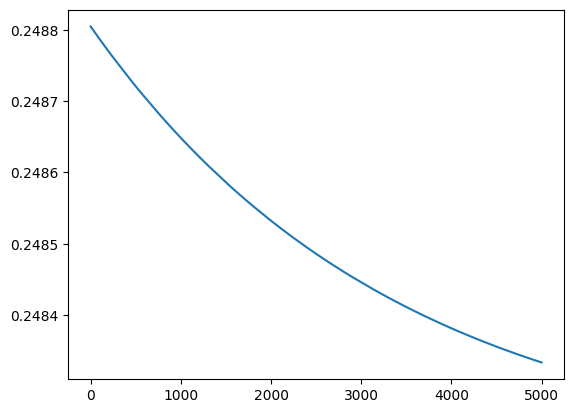

In [213]:
for name, parameter in model.named_parameters():
  print(name, parameter)

y_pred = model.forward(X_LRtrainvalid.to(torch.float32))
print(y_pred[:10])

test = np.where(y_pred.detach().cpu().numpy() < 0.5, 0, 1)
print(test[:10])

all_loss = []
for epoch in range(5000):
  y_hat = model(X_LRtrainvalid.to(torch.float32))

  loss = criterion(y_hat, Y_trainvalid)
  all_loss.append (loss.item())
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

plt.plot(all_loss)

In [111]:
colnames=["data","model","seed","epochs","accuracy", "precision", "recall", "f1", "auc","prc", "LR00", "LR01", "LR10", "LR11", "time", "K"]
output = pd.DataFrame(columns=colnames)#(), index=['x','y','z'])


for K in range(1,4):
    # fit the logistic regression model
    for randnum in range(0,1):
        print("  Random seed: ",randnum)
        runtime, acc, prec, rec, fone, auc, prc, LR00, LR01, LR10, LR11 = SIGmodel_block_original(X_trainvalid=X_trainvalid,Y_trainvalid=Y_trainvalid,X_test=X_test,Y_test=Y_test,K=K, randnum=randnum)
        
        # Formatting and saving the output
        outputs=[name, model_name, randnum, epochs,  acc, prec, rec, fone, auc,prc, LR00, LR01, LR10, LR11, runtime, K]
        entry = pd.DataFrame([outputs], columns=colnames)
        output = pd.concat([output, entry], ignore_index=True)
print(output)

  Random seed:  0
Random state set:0, cuda used: True
Original
num features = 9; num timepoints = 40
sig length = 10


KeyboardInterrupt: 